## Imports and Setup

In [1]:
import os
import pandas as pd
import geopandas as gpd
import logging
import torch

import sys
sys.path.insert(0, "../utils/")
import model_utils
import config_utils
import embed_utils

%load_ext autoreload
%autoreload 2

## Data Configurations

In [20]:
iso_code = "RWA"
cwd = os.path.dirname(os.getcwd())
config_file = os.path.join(cwd, f"configs/model_configs/dinov2_vits14-LR.yaml")
config = config_utils.load_config(config_file)
config["iso_codes"] = [iso_code]

## Load Model

In [21]:
model = torch.hub.load("facebookresearch/dinov2", config["embed_model"])
model.name = config["embed_model"]
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
model.to(device)

Using cache found in /home/itingzon.unicef/.cache/torch/hub/facebookresearch_dinov2_main
INFO:dinov2:using MLP layer as FFN


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x NestedTensorBlock(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
  )
  (n

## Load Data

In [22]:
data = model_utils.load_data(config, attributes=["rurban", "iso"], verbose=True)
data.head(3)

INFO:root:Reading file /home/itingzon.unicef/giga/data/vectors/train/RWA_train.geojson
INFO:root:
  rurban  iso       class  count  percentage
0  rural  RWA  non_school    227    0.036857
1  rural  RWA      school     81    0.013151
2  urban  RWA  non_school   3108    0.504627
3  urban  RWA      school   2743    0.445365
INFO:root:
                               count  percentage
rurban iso class      dataset                   
rural  RWA non_school test        43    0.034931
                      train      184         NaN
           school     test        18    0.014622
                      train       63         NaN
urban  RWA non_school test       625    0.507717
                      train     2483         NaN
           school     test       544    0.441917
                      train     2199         NaN
INFO:root:
                    count
dataset class            
test    non_school    668
        school        562
train   non_school   2667
        school       2262
INFO:root

,UID,source,iso,country,region,subregion,name,giga_id_school,clean,validated,class,ghsl_smod,rurban,dataset,geometry
0,AUG-RWA-NON_SCHOOL-00124188,AUG,RWA,Rwanda,Africa,Sub-Saharan Africa,None,None,0,0,school,21,urban,train,POINT (2941733.638 -247290.833)
1,OVERTURE-RWA-SCHOOL-00000000,OVERTURE,RWA,Rwanda,Africa,Sub-Saharan Africa,Wellspring Academy,None,0,0,school,30,urban,train,POINT (3016263.969 -240344.242)
2,OVERTURE-RWA-SCHOOL-00000002,OVERTURE,RWA,Rwanda,Africa,Sub-Saharan Africa,HBT.Academy,None,0,0,school,21,urban,train,POINT (3039212.123 -216365.626)


## Urban Schools

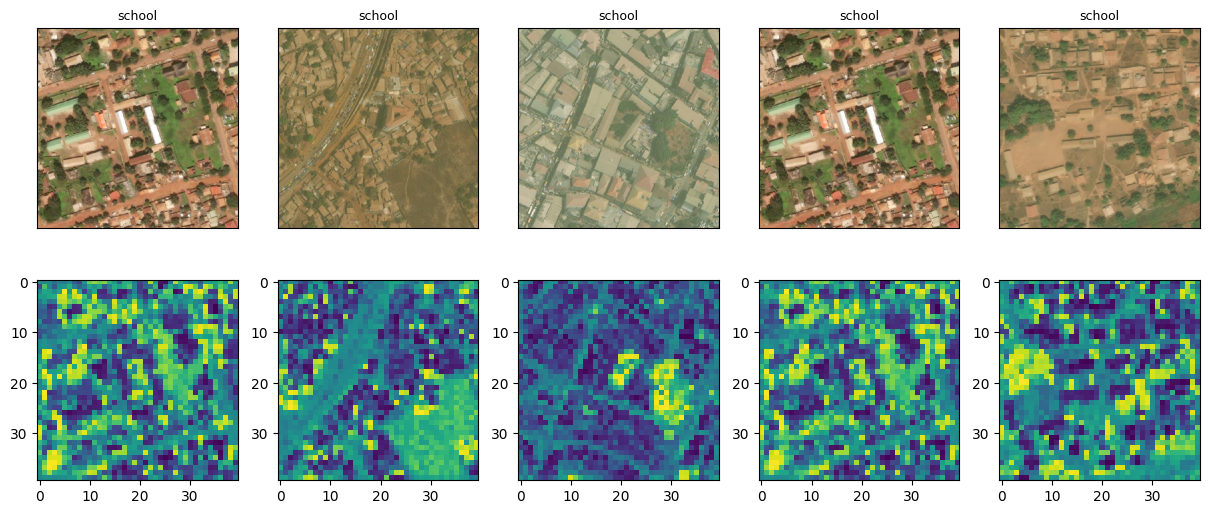

In [17]:
subdata = data[(data.rurban=="urban") & (data["class"] == "school")]
embed_utils.visualize_embeddings(config, subdata, model, batch_size=5)

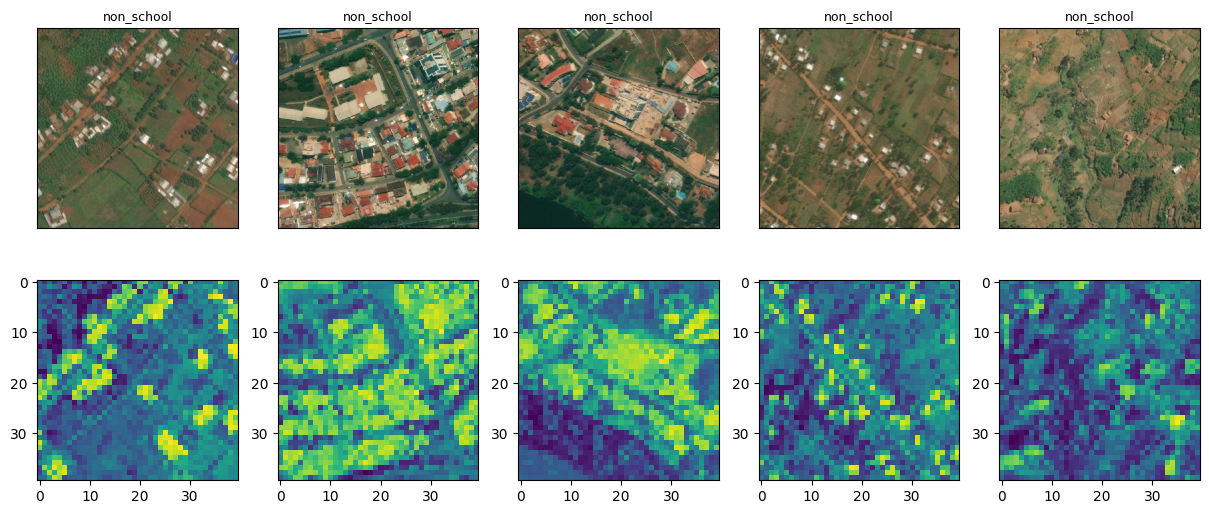

In [23]:
subdata = data[(data.rurban=="urban") & (data["class"] == "non_school")]
embed_utils.visualize_embeddings(config, subdata, model, batch_size=5)

## Rural Schools

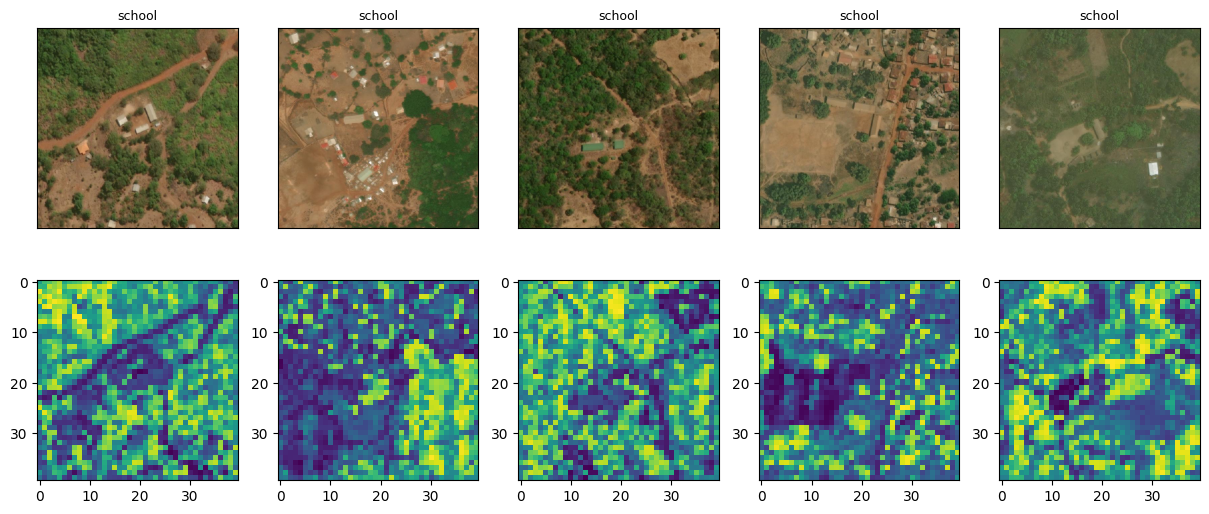

In [16]:
subdata = data[(data.rurban=="rural") & (data["class"] == "school")]
embed_utils.visualize_embeddings(config, subdata, model, batch_size=5)

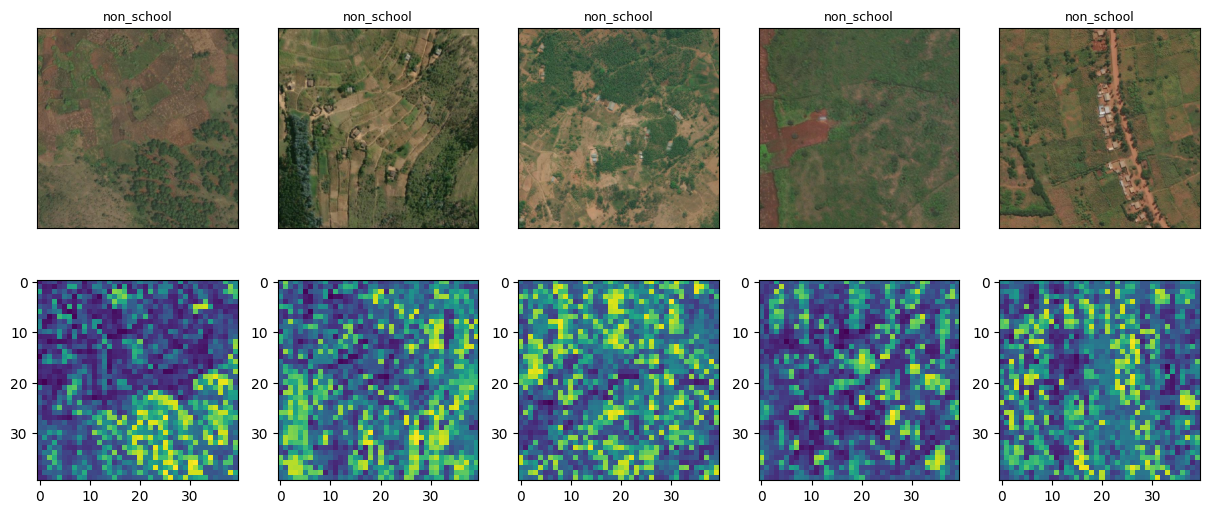

In [24]:
subdata = data[(data.rurban=="rural") & (data["class"] == "non_school")]
embed_utils.visualize_embeddings(config, subdata, model, batch_size=5)

## Compute Embeddings

In [16]:
out_dir = os.path.join(config["vectors_dir"], "embeddings")
embeddings = embed_utils.get_image_embeddings(
    config, data, model, out_dir, in_dir=None, columns=["iso", "rurban", "dataset", "class"]
)
embeddings.head(3)

INFO:root:Reading file /home/itingzon.unicef/giga/data/vectors/embeddings/MNG_dinov2_vits14_embeds.csv


,UID,0,1,2,3,4,5,6,7,8,...,378,379,380,381,382,383,iso,rurban,dataset,class
0,OVERTURE-MNG-SCHOOL-00000005,-2.888033,-0.108523,5.691371,-2.143276,0.669561,-2.958966,-2.102606,0.754148,-0.106829,...,1.265511,-3.531531,-0.315876,1.205464,-2.272689,3.702338,MNG,urban,train,school
1,OVERTURE-MNG-SCHOOL-00000006,-2.589591,-0.156911,5.571325,-4.166053,0.541174,-0.911260,-2.040312,-0.669896,-1.048705,...,1.132965,-1.922010,1.084568,2.454362,-5.554929,3.728537,MNG,urban,train,school
2,OVERTURE-MNG-SCHOOL-00000018,-2.531917,0.847107,3.817045,-2.197662,2.105122,-0.644953,-2.360759,0.050235,1.632953,...,2.703199,-2.559021,-0.785523,0.349606,-3.324399,4.424771,MNG,urban,train,school
